In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import PointsStrokesTransformer
from lib.strokes import VectorsStrokesTransformer
from lib.strokes import PolarStrokesTransformer
from lib.strokes import get_n_points, cut_strokes
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.dataset import PADDING_VALUE
from lib.plot import get_canvas, plot, get_animation
from lib.model import Encoder, Decoder, EncoderDecoder
from lib.model import evaluate, generate, train
from lib.model import get_reg_loss, get_classif_loss, get_loss

# Load and show dataset

In [4]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

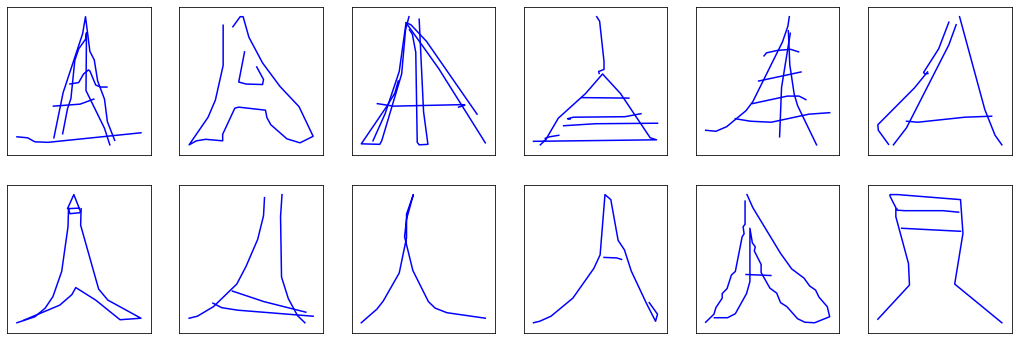

In [6]:
fig, axarr = get_canvas(2, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

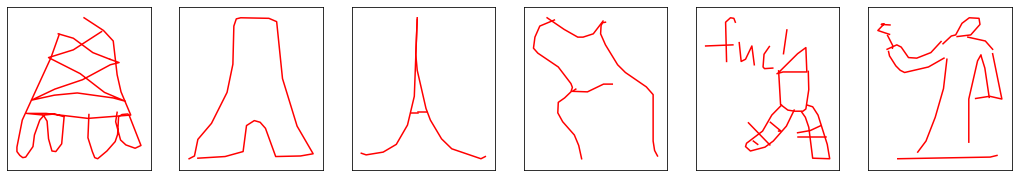

In [7]:
fig, axarr = get_canvas(1, 6)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

In [10]:
anim.save('effeil.gif', dpi=80, writer='imagemagick')

# Transform drawings

to an internal representation suitable for modeling

Text(0.5, 1.0, 'y')

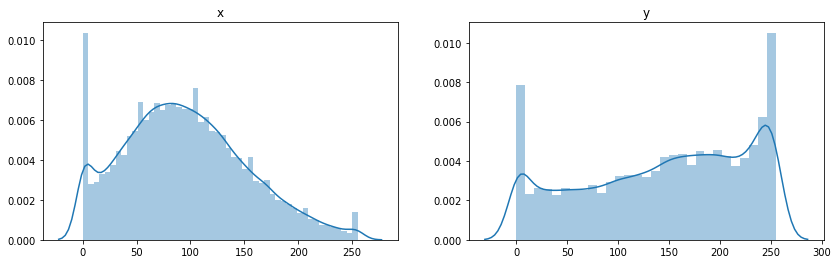

In [11]:
transform = PointsStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

xs, ys = [], []
for transformed_drawing in transformed_drawings:
    xs += list(map(operator.itemgetter(0), transformed_drawing))
    ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(xs, ax=axs[0]).set_title('x')
sns.distplot(ys, ax=axs[1]).set_title('y')

Stroke points do not follow a gaussian distribution.

Text(0.5, 1.0, 'delta_y')

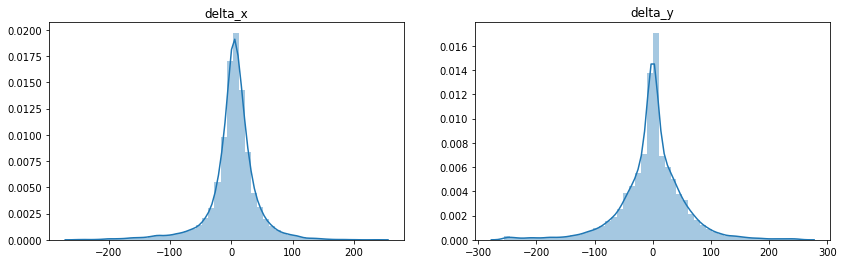

In [12]:
transform = VectorsStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

Stroke vectors follow a gaussian distribution.

Text(0.5, 1.0, 'alpha')

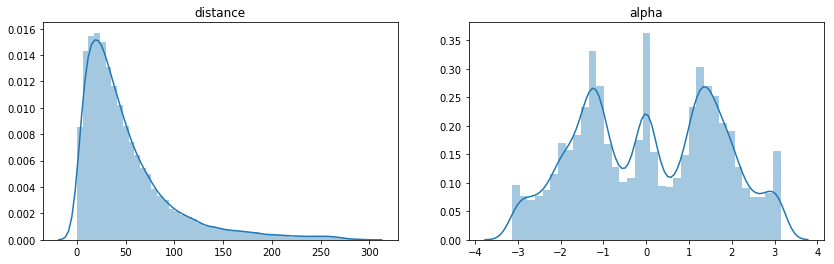

In [13]:
transform = PolarStrokesTransformer().transform
transformed_drawings = [transform(good_drawings[i]) for i in range(1000)]

distances, alphas = [], []
for transformed_drawing in transformed_drawings:
    distances += list(map(operator.itemgetter(0), transformed_drawing))
    alphas += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(distances, ax=axs[0]).set_title('distance')
sns.distplot(alphas, ax=axs[1]).set_title('alpha')

Stroke polar-coordinates vectors do not follow a gaussian distribution.

# Create pytorch dataset

In [14]:
transformer = VectorsStrokesTransformer()
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transformer.transform(drawing) for drawing in drawings]

In [15]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [16]:
ds = get_dataset(transformed_drawings)

In [17]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=1)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(1, 1)

In [18]:
standarize = True
sigmas = 1

if standarize:
    train_means_stds = get_means_stds(train_ds, sigmas)
    val_means_stds = get_means_stds(val_ds, sigmas)
else:
    train_means_stds = ([0, 1], [0, 1])
    val_means_stds = ([0, 1], [0, 1])

In [19]:
# Debug
train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lens_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lens_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lens_batch):
    print(tensor)
    print()

torch.Size([34, 1, 5]) torch.Size([34, 1, 5]) torch.Size([1])


tensor([[[ 0.3171,  0.0825,  1.0000,  0.0000,  0.0000]],

        [[ 0.1950,  0.1929,  1.0000,  0.0000,  0.0000]],

        [[ 0.4044,  0.0604,  1.0000,  0.0000,  0.0000]],

        [[ 3.2656, -0.3371,  1.0000,  0.0000,  0.0000]],

        [[-3.1897,  0.2370,  0.0000,  1.0000,  0.0000]],

        [[ 0.2648, -1.7723,  1.0000,  0.0000,  0.0000]],

        [[ 0.6312, -2.3243,  1.0000,  0.0000,  0.0000]],

        [[ 0.0380, -0.6462,  1.0000,  0.0000,  0.0000]],

        [[ 0.0903,  1.4294,  1.0000,  0.0000,  0.0000]],

        [[ 0.0903,  0.3916,  1.0000,  0.0000,  0.0000]],

        [[ 0.0554,  0.8774,  1.0000,  0.0000,  0.0000]],

        [[ 0.1775,  0.7670,  1.0000,  0.0000,  0.0000]],

        [[ 0.0380,  0.9436,  1.0000,  0.0000,  0.0000]],

        [[ 0.1950,  0.7670,  1.0000,  0.0000,  0.0000]],

        [[-1.9335, -0.2267,  0.0000,  1.0000,  0.0000]],

        [[ 0.1078, -0.9553,  1.0000,  0.0000,  0.0000]],

        

In [20]:
batch_size = 1024
n_hidden = 20

model = EncoderDecoder(batch_size, n_hidden)

if torch.cuda.is_available():
    model = model.cuda()

In [21]:
train_batches = get_batches(train_ds, train_means_stds, batch_size=3)
data_batch, labels_batch, lens_batch = next(iter(train_batches))

preds_batch = model(data_batch, lens_batch)

In [23]:
preds_batch

tensor([[[0.0749, 0.2614, 0.2839, 0.3850, 0.3312]],

        [[0.0525, 0.2431, 0.2840, 0.3904, 0.3256]],

        [[0.0466, 0.2326, 0.2848, 0.3942, 0.3211]],

        [[0.0753, 0.2146, 0.2847, 0.3896, 0.3257]],

        [[0.0387, 0.2562, 0.2823, 0.3836, 0.3342]],

        [[0.0691, 0.2561, 0.2870, 0.3955, 0.3175]],

        [[0.0874, 0.2684, 0.2872, 0.4009, 0.3119]],

        [[0.0746, 0.2699, 0.2852, 0.4032, 0.3116]],

        [[0.0390, 0.2402, 0.2842, 0.3968, 0.3191]],

        [[0.0332, 0.2293, 0.2850, 0.3967, 0.3183]],

        [[0.0213, 0.2165, 0.2852, 0.3941, 0.3207]],

        [[0.0178, 0.2091, 0.2854, 0.3936, 0.3210]],

        [[0.0102, 0.2028, 0.2855, 0.3920, 0.3225]],

        [[0.0113, 0.2007, 0.2857, 0.3924, 0.3219]],

        [[0.0287, 0.2486, 0.2833, 0.3926, 0.3242]],

        [[0.0559, 0.2458, 0.2856, 0.3991, 0.3153]],

        [[0.0499, 0.2440, 0.2853, 0.4007, 0.3140]],

        [[0.0637, 0.2564, 0.2856, 0.4042, 0.3102]],

        [[0.0578, 0.2551, 0.2851, 0.4040, 0.31

# Train

In [184]:
batch_size = 1024
n_hidden = 256

model = EncoderDecoder(batch_size, n_hidden)
if torch.cuda.is_available():
    model = model.cuda()

criterion = get_loss
optimizer = Adam(model.parameters(), 1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)

In [189]:
print(model)

EncoderDecoder(
  (encoder): Encoder(
    (lstm): LSTM(5, 256)
  )
  (decoder): Decoder(
    (hidden_bridge): Linear(in_features=256, out_features=256, bias=True)
    (cell_bridge): Linear(in_features=256, out_features=256, bias=True)
    (lstm): LSTM(5, 256)
    (output_weights): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [186]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=200, epochs_between_evals=10)

epoch:   1   train_loss: 1.08371   val_loss: 1.08371         reg_classif_loss_ratio: 5.30
epoch:  10   train_loss: 0.76841   val_loss: 0.76841         reg_classif_loss_ratio: 7.92
epoch:  20   train_loss: 0.31616   val_loss: 0.31616         reg_classif_loss_ratio: 12.59
epoch:  30   train_loss: 0.15814   val_loss: 0.15814         reg_classif_loss_ratio: 7.44
epoch:  40   train_loss: 0.08704   val_loss: 0.08704         reg_classif_loss_ratio: 4.52
epoch:  50   train_loss: 0.05822   val_loss: 0.05822         reg_classif_loss_ratio: 3.87
epoch:  60   train_loss: 0.01556   val_loss: 0.01556         reg_classif_loss_ratio: 8.87
epoch:  70   train_loss: 0.00844   val_loss: 0.00844         reg_classif_loss_ratio: 17.63
epoch:  80   train_loss: 0.00333   val_loss: 0.00333         reg_classif_loss_ratio: 17.24
epoch:  90   train_loss: 0.00180   val_loss: 0.00180         reg_classif_loss_ratio: 13.91
epoch: 100   train_loss: 0.00108   val_loss: 0.00108         reg_classif_loss_ratio: 10.98
epoch

In [190]:
torch.save(model.state_dict(), 'model1.pth')

In [191]:
#train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
#      epochs=100, epochs_between_evals=10)

In [192]:
#torch.save(model.state_dict(), 'model2.pth')

In [193]:
#train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
#      epochs=100, epochs_between_evals=10)

In [194]:
#torch.save(model.state_dict(), 'model3.pth')

# Predict

In [195]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load('model1.pth', map_location=map_location))

In [196]:
n_initial_points = 3

idx = np.random.choice(len(val_ds))
flat_strokes = val_ds[idx][0].tolist()
start_of_stroke = flat_strokes[:n_initial_points]
start_of_stroke = torch.Tensor(start_of_stroke).unsqueeze(dim=1)
standarize_data(start_of_stroke, get_means_stds(val_ds))

In [197]:
pred_flat_strokes = generate(model, start_of_stroke, 50)
pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
pred_flat_strokes

[[22, 2, 1, 0, 0],
 [15, 7, 1, 0, 0],
 [27, 1, 1, 0, 0],
 [119, -23, 1, 0, 0],
 [-176, -31, 0, 1, 0],
 [22, -60, 1, 0, 0],
 [30, -87, 1, 0, 0],
 [6, -21, 1, 0, 0],
 [9, 57, 1, 0, 0],
 [10, 18, 1, 0, 0],
 [7, 40, 1, 0, 0],
 [16, 39, 1, 0, 0],
 [10, 42, 1, 0, 0],
 [-2, 29, 1, 0, 0],
 [-117, -40, 0, 1, 0],
 [24, -28, 1, 0, 0],
 [3, -22, 1, 0, 0],
 [8, -51, 1, 0, 0],
 [8, -16, 1, 0, 0],
 [14, -13, 1, 0, 0],
 [0, 2, 1, 0, 0],
 [6, 103, 1, 0, 0],
 [43, 45, 1, 0, 0],
 [-33, 14, 1, 0, 0],
 [-88, -86, 0, 1, 0],
 [19, -1, 1, 0, 0],
 [11, -20, 1, 0, 0],
 [9, -14, 1, 0, 0],
 [7, 1, 1, 0, 0],
 [14, 14, 1, 0, 0],
 [6, 6, 1, 0, 0],
 [18, 21, 1, 0, 0],
 [-87, 43, 0, 1, 0],
 [10, -6, 1, 0, 0],
 [11, -1, 0, 0, 1],
 [-43, -80, 0, 1, 0],
 [26, -31, 1, 0, 0],
 [5, -66, 1, 0, 0],
 [6, -27, 1, 0, 0],
 [3, 20, 1, 0, 0],
 [12, 82, 1, 0, 0],
 [24, 82, 1, 0, 0],
 [30, 37, 1, 0, 0],
 [-61, -41, 0, 1, 0],
 [-22, -29, 1, 0, 0],
 [18, -4, 1, 0, 0],
 [10, -41, 1, 0, 0],
 [4, -13, 1, 0, 0],
 [16, 0, 1, 0, 0],
 [4, 2, 

In [198]:
%%capture

from lib.plot import get_animation

strokes = transformer.inverse_transform(flat_strokes)
anim = get_animation(strokes)

cut_drawing = cut_strokes(strokes, n_initial_points)
cut_anim = get_animation(cut_drawing)

pred_strokes = transformer.inverse_transform(pred_flat_strokes)
pred_anim = get_animation(pred_strokes)

In [199]:
# Ground truth drawing
HTML(anim.to_html5_video())

In [200]:
# Ground truth drawing
HTML(cut_anim.to_html5_video())

In [201]:
# Generated drawing
HTML(pred_anim.to_html5_video())